In [1]:
import sys
import os
import torch
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(".."))

import AstroChemNet.data_processing as dp
from AstroChemNet.inference import Inference
import AstroChemNet.data_loading as dl
from autoencoder.config import (
    GeneralConfig,
    AEConfig,
)
from autoencoder.training import (
    load_autoencoder,
)

In [2]:
autoencoder = load_autoencoder(GeneralConfig, AEConfig, inference=True)

processing = dp.Processing(GeneralConfig, AEConfig)
inference = Inference(
    GeneralConfig,
    processing,
    autoencoder,
)

Loading Pretrained Model
Latents MinMax: -0.16997122764587402, 25.426658630371094


In [3]:
training_np, validation_np = dl.load_datasets(GeneralConfig, AEConfig.columns)
del training_np

processing.abundances_scaling(validation_np)
validation_dataset = torch.from_numpy(validation_np)

validation_Dataset = dl.AutoencoderDataset(validation_dataset)

validation_dataloader = dl.tensor_to_dataloader(AEConfig, validation_Dataset)

Data_matrix Memory usage: 941.307 MB


In [4]:
stoichiometric_matrix = torch.tensor(
    GeneralConfig.stoichiometric_matrix, device=GeneralConfig.device
).float()


def calculate_conservation_error(outputs, targets):
    targets = processing.inverse_abundances_scaling(targets)
    cons_outputs = torch.abs(torch.matmul(outputs, stoichiometric_matrix))
    cons_targets = torch.abs(torch.matmul(targets, stoichiometric_matrix))

    conservation_error = torch.abs(cons_outputs - cons_targets) / cons_targets
    return conservation_error.mean()

In [5]:
conservation_error = 0
for i, features in enumerate(validation_dataloader):
    features = features[0].to(GeneralConfig.device)
    latents = inference.encode(features)
    outputs = inference.decode(latents)

    j = calculate_conservation_error(outputs, features)
    conservation_error += j

conservation_error /= len(validation_dataloader)
print(f"{conservation_error.item():.8f}")

0.00103122


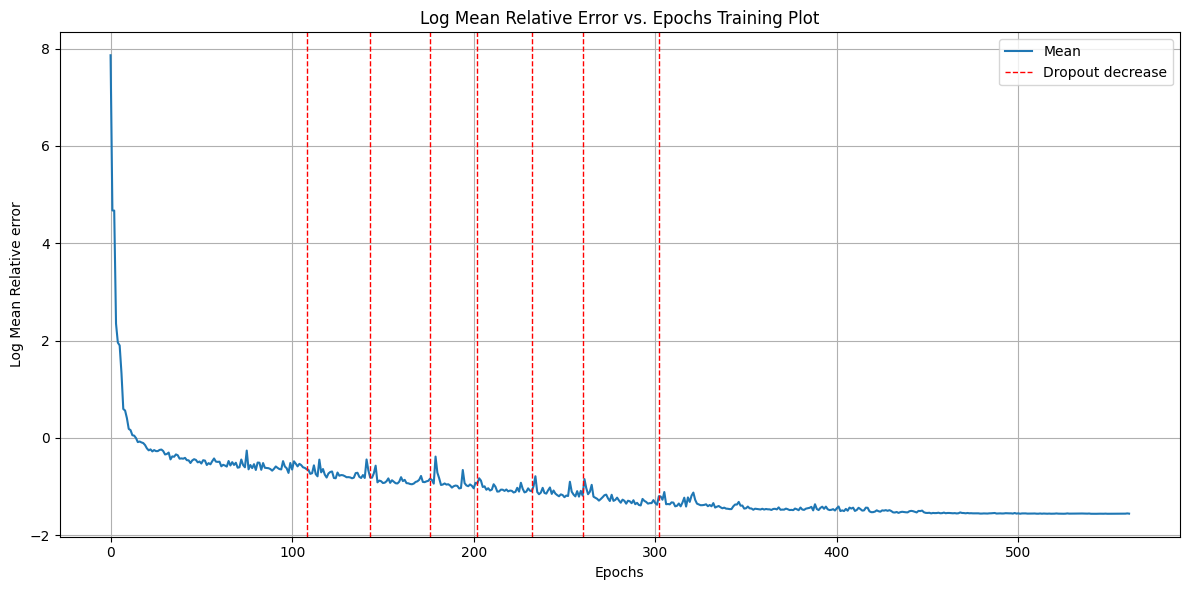

,mean,std,max,metric,dropout,learning_rate
0,7.324720e+07,3.448884e+08,3.596660e+09,7.324720e+07,0.3,0.001
1,4.736225e+04,1.215098e+05,1.039336e+06,4.736225e+04,0.3,0.001
2,4.693327e+04,6.815062e+05,1.241028e+07,4.693327e+04,0.3,0.001
3,2.221572e+02,8.294232e+02,1.019288e+04,2.221572e+02,0.3,0.001
4,9.089684e+01,4.018147e+02,4.552747e+03,9.089684e+01,0.3,0.001
...,...,...,...,...,...,...
557,2.750912e-02,1.946058e-02,1.500755e-01,2.750912e-02,0.0,0.001
558,2.767409e-02,1.947844e-02,1.477807e-01,2.767409e-02,0.0,0.001
559,2.765081e-02,1.950694e-02,1.480416e-01,2.765081e-02,0.0,0.001
560,2.797401e-02,1.957193e-02,1.487649e-01,2.797401e-02,0.0,0.001


In [6]:
epochs_path = os.path.splitext(AEConfig.save_model_path)[0] + ".json"

with open(epochs_path, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
plt.plot(df.index, np.log10(df["mean"]), label="Mean")

dropout_changes = df["dropout"].diff() < 0
for idx in df.index[dropout_changes]:
    plt.axvline(
        x=idx,
        color="red",
        linestyle="--",
        linewidth=1,
        label="Dropout decrease"
        if "Dropout decrease" not in plt.gca().get_legend_handles_labels()[1]
        else "",
    )

lr_changes = df["learning_rate"].diff() < 0
for idx in df.index[lr_changes]:
    plt.axvline(
        x=idx,
        color="blue",
        linestyle="--",
        linewidth=1,
        label="Learning rate decrease"
        if "Learning rate decrease" not in plt.gca().get_legend_handles_labels()[1]
        else "",
    )

plt.title("Log Mean Relative Error vs. Epochs Training Plot")
plt.xlabel("Epochs")
plt.ylabel("Log Mean Relative error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df